# Ensemble without assimilating 

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy
import xarray as xr
from tqdm import tqdm
import glob
from devtools import pprint
from tqdm import tqdm

In [2]:
# general eWC
import ewatercycle
import ewatercycle.forcing
import ewatercycle.models

**set up paths**

In [3]:
path = Path.cwd()
forcing_path = path / "Forcing"
observations_path = path / "Observations"
figure_path = path / "Figures"
output_path = path / "Output"

## Marrmot 

**add forcing**

In [4]:
from ewatercycle.forcing import sources

In [5]:
marrmot_forcing = ewatercycle.forcing.sources["MarrmotForcing"](
    directory=forcing_path,
    start_time="1989-01-01T00:00:00Z",
    end_time="1992-12-31T00:00:00Z",
    forcing_file="BMI_testcase_m01_BuffaloRiver_TN_USA.mat",
)

**import model**

In [6]:
ewatercycle.models.sources.MarrmotM14

ewatercycle_marrmot.model.MarrmotM14

In [7]:
from ewatercycle.models import MarrmotM14

**import DA function**

```py
pip install ewatercycle_DA
```

In [11]:
from ewatercycle_DA import DA

In [12]:
n_particles = 3

In [13]:
ensemble = DA.Ensemble(N=n_particles)
ensemble.setup()

In [14]:
maximum_soil_moisture_storage_lst = [10.0, 12.0, 14.0]

In [15]:
# values wihch you 
setup_kwargs_lst = []
for index in range(n_particles):
    setup_kwargs_lst.append({'maximum_soil_moisture_storage': maximum_soil_moisture_storage_lst[index], 
                            'end_time':'1989-02-01T00:00:00Z',
                             })

In [16]:
ensemble.ensemble_list[0].model_name

In [18]:
# this initializes the models for all ensemble members. - ignore warnings for now 
ensemble.initialize(model_name=["MarrmotM14"]*n_particles,
                    forcing=[marrmot_forcing]*n_particles,
                    setup_kwargs=setup_kwargs_lst) 

**Run**

In [19]:
ref_model = ensemble.ensemble_list[0].model

In [20]:
n_timesteps = int((ref_model.end_time - ref_model.start_time) /  ref_model.time_step)

time = []
lst_Q = [] 
for i in tqdm(range(n_timesteps)):    
    time.append(pd.Timestamp(ref_model.time_as_datetime.date()))
    ensemble.update()
    lst_Q.append(ensemble.get_value("flux_out_Q").flatten())

ensemble.finalize()

100%|███████████████████████████████████████████████████████████████████████████████████| 31/31 [00:02<00:00, 14.34it/s]


In [21]:
Q_m_arr = np.array(lst_Q).T
df_ensemble = pd.DataFrame(data=Q_m_arr[:,:len(time)].T,index=time,columns=[f'particle {n}' for n in range(n_particles)])

<Axes: >

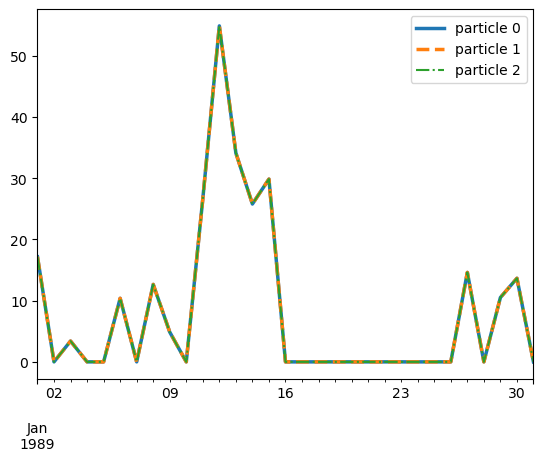

In [22]:
ax = df_ensemble[["particle 0"]].plot(lw=2.5)
df_ensemble[["particle 1"]].plot(ax=ax,ls="--",lw=2.5)
df_ensemble[["particle 2"]].plot(ax=ax,ls="-.",lw=1.5)